In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [9]:
# Load data
df = pd.read_csv('D:\Python\demand-prediction\Dataset\SKU3.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Split data into training, validation, and test sets immediately after import
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

train = df.iloc[:train_size]
val = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]

# Add month and day of the week to all datasets
for dataset in [train, val, test]:
    dataset['month'] = dataset.index.month
    dataset['day_of_week'] = dataset.index.dayofweek

# Scale 'sales' separately
sales_scaler = MinMaxScaler()
train['sales_scaled'] = sales_scaler.fit_transform(train[['sales']])
val['sales_scaled'] = sales_scaler.transform(val[['sales']])
test['sales_scaled'] = sales_scaler.transform(test[['sales']])

# Scale other numerical features
numerical_features = ['month', 'day_of_week']
feature_scaler = MinMaxScaler()
train[numerical_features] = feature_scaler.fit_transform(train[numerical_features])
val[numerical_features] = feature_scaler.transform(val[numerical_features])
test[numerical_features] = feature_scaler.transform(test[numerical_features])

# Define features for the model
features = ['sales_scaled', 'month', 'day_of_week']
target = 'sales_scaled'

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0218 - val_loss: 0.0096
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0110 - val_loss: 0.0090
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0120 - val_loss: 0.0088
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0111 - val_loss: 0.0087
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0112 - val_loss: 0.0089
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

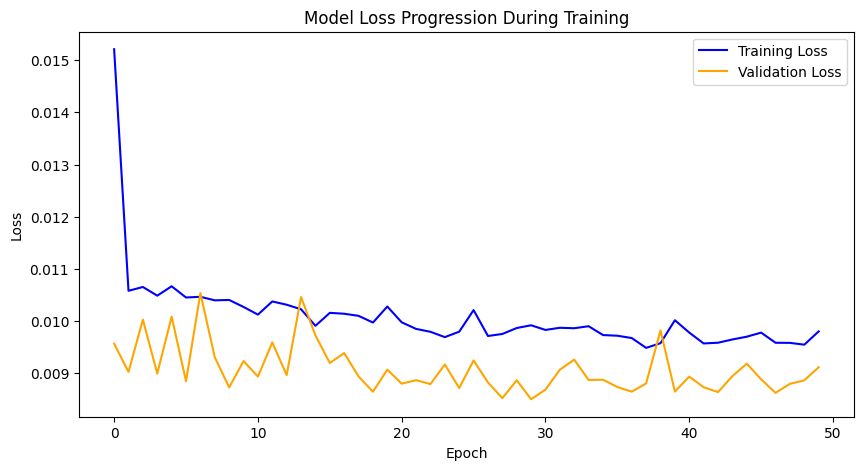

In [10]:
# Define sequence length
sequence_length = 30

def create_sequences(data, features, target, sequence_length):
    X, y = [], []
    data_values = data[features].values
    target_values = data[target].values
    for i in range(sequence_length, len(data)):
        X.append(data_values[i - sequence_length:i])
        y.append(target_values[i])
    return np.array(X), np.array(y)

# Create sequences for training and validation
X_train, y_train = create_sequences(train, features, target, sequence_length)
X_val, y_val = create_sequences(val, features, target, sequence_length)

# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
39/39 ━━━━━━━━━━━━━━━━━━━

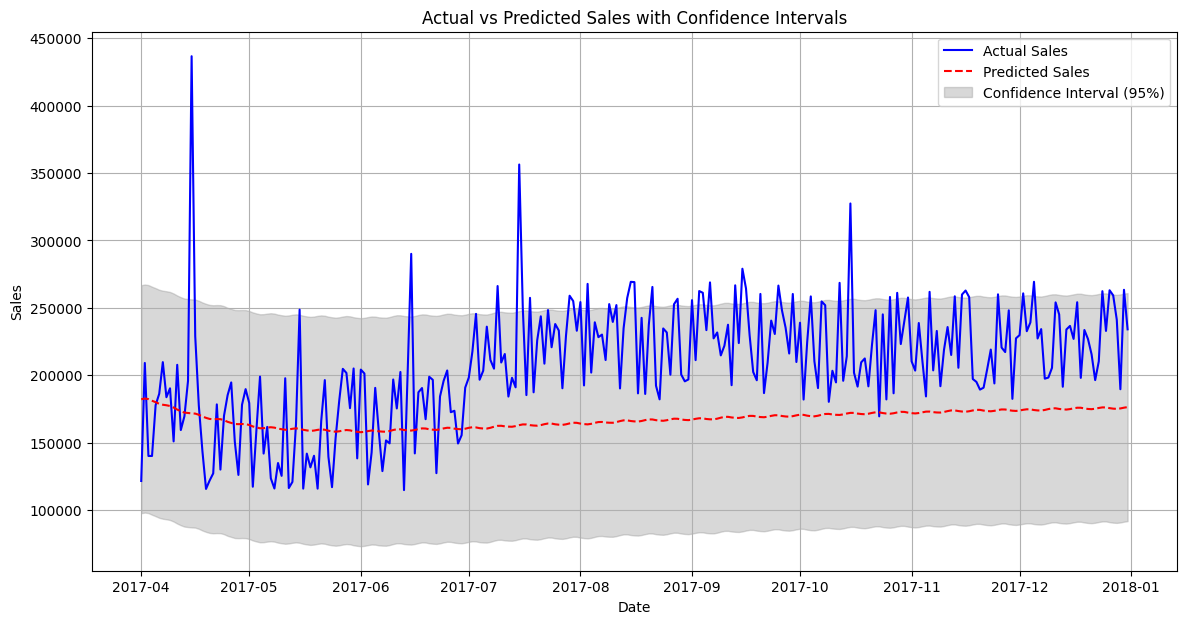

In [11]:
# Rolling window predictions on the test set period
test_values = test[features].values # test the date of test set to do prediction in order to match predition and test set

# Initialize the sequence with the last sequence from the training set
last_train_sequence = train[features].values[-sequence_length:]

current_sequence = last_train_sequence.copy()
predictions = []
prediction_intervals = []
dates = test.index

for i in range(len(test)):
    # Prepare the input sequence
    input_sequence = np.array([current_sequence])
    
    # Make prediction
    pred = model.predict(input_sequence)
    
    # Store the prediction
    predictions.append(pred[0][0])
    
    # Calculate confidence interval (using a simple approximation with standard deviation of residuals)
    residuals = y_train - model.predict(X_train).flatten()
    std_residuals = np.std(residuals)
    lower_bound = pred[0][0] - 1.96 * std_residuals
    upper_bound = pred[0][0] + 1.96 * std_residuals
    prediction_intervals.append((lower_bound, upper_bound))
    
    # Prepare the next input sequence
    new_entry = test_values[i].copy()
    new_entry[0] = pred[0][0]  # Replace 'sales_scaled' with the predicted value
    
    # Update the current sequence
    current_sequence = np.vstack((current_sequence[1:], new_entry))

# Inverse transform predictions and actual values
predictions_inv = sales_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_inv = sales_scaler.inverse_transform(test[target].values.reshape(-1, 1))

# Inverse transform prediction intervals
lower_bounds_inv = sales_scaler.inverse_transform(np.array([interval[0] for interval in prediction_intervals]).reshape(-1, 1))
upper_bounds_inv = sales_scaler.inverse_transform(np.array([interval[1] for interval in prediction_intervals]).reshape(-1, 1))

# Create a DataFrame for analysis
test_results = pd.DataFrame({
    'date': dates,
    'actual_sales': actual_inv.flatten(),
    'predicted_sales': predictions_inv.flatten(),
    'lower_bound': lower_bounds_inv.flatten(),
    'upper_bound': upper_bounds_inv.flatten()
})

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test_results['date'], test_results['actual_sales'], label='Actual Sales', color='blue')
plt.plot(test_results['date'], test_results['predicted_sales'], label='Predicted Sales', color='red', linestyle='--')
plt.fill_between(test_results['date'], test_results['lower_bound'], test_results['upper_bound'], color='gray', alpha=0.3, label='Confidence Interval (95%)')
plt.title('Actual vs Predicted Sales with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Calculate MAE, MAPE, MSE, and R2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
mae = mean_absolute_error(test_results['actual_sales'], test_results['predicted_sales'])
mape = mean_absolute_percentage_error(test_results['actual_sales'], test_results['predicted_sales'])
mse = mean_squared_error(test_results['actual_sales'], test_results['predicted_sales'])
r2 = r2_score(test_results['actual_sales'], test_results['predicted_sales'])

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

MAE: 48782.4788
MSE: 3442979292.1486
MAPE: 0.2221
R2: -0.7532


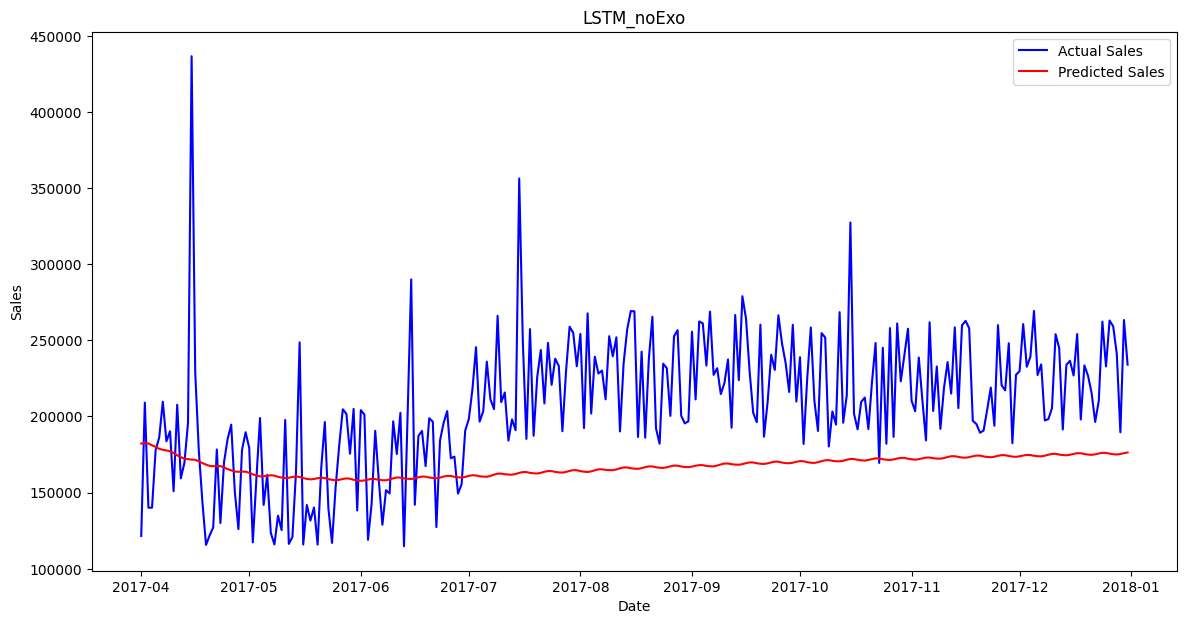

In [13]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test_results['date'], test_results['actual_sales'], label='Actual Sales', color='blue')
plt.plot(test_results['date'], test_results['predicted_sales'], label='Predicted Sales', color='red')
# plt.fill_between(test_results['date'], test_results['lower_bound'], test_results['upper_bound'], color='gray', alpha=0.3, label='Confidence Interval (95%)')
plt.title('LSTM_noExo')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(False)
plt.show()

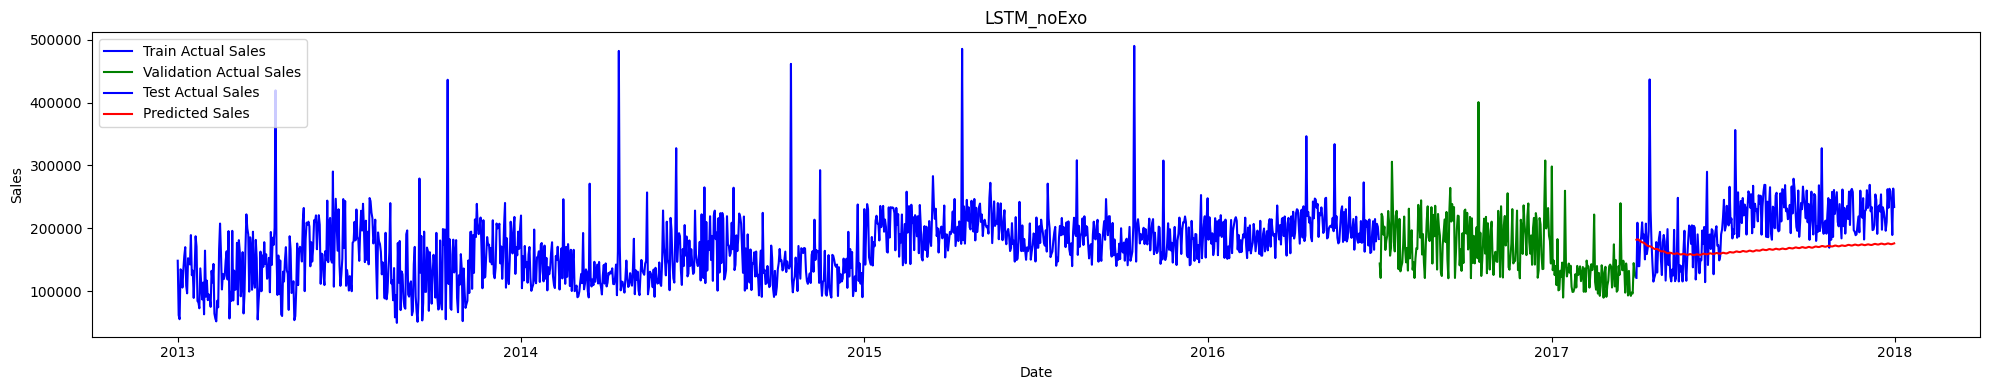

In [14]:
# Plot the entire graph for train, validation, test, and prediction

# Prepare inverse-transformed data for train and validation sets as well
train_sales_inv = sales_scaler.inverse_transform(train['sales_scaled'].values.reshape(-1, 1))
val_sales_inv = sales_scaler.inverse_transform(val['sales_scaled'].values.reshape(-1, 1))

# Define indices for easier plotting
train_idx = train.index
val_idx = val.index
test_idx = test_results['date']

# Plot the actual sales and predictions across the train, validation, and test sets
plt.figure(figsize=(20, 4))
plt.plot(train_idx, train_sales_inv, label='Train Actual Sales', color='blue')
plt.plot(val_idx, val_sales_inv, label='Validation Actual Sales', color='green')
plt.plot(test_idx, test_results['actual_sales'], label='Test Actual Sales', color='blue')
plt.plot(test_idx, test_results['predicted_sales'], label='Predicted Sales', color='red')

# Add title and labels for clarity
plt.title('LSTM_noExo')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
